Let's try with a CNN LSTM Neural Network

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

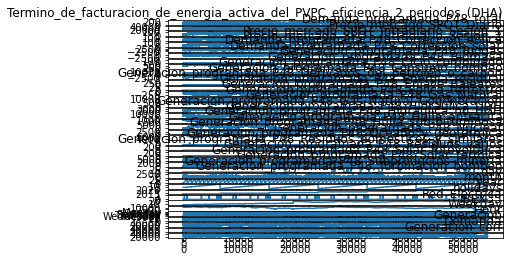

In [3]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

values = df.values
# specify columns to plot
groups = np.arange(len(df.columns.to_list()))
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.rcParams['figure.figsize'] = [50, 25]
plt.show()

In [4]:
model_columns = ['Demanda_programada_P48_total', 'Precio_mercado_SPOT_Diario','Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo','Generacion_programada_P48_Enlace_Baleares','Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hulla_antracita','Generacion_programada_P48_Hulla_sub-bituminosa','Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica','Generacion_programada_P48_Turbinacion_bombeo','IBEX35',
                 'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 'Weekday_Friday', 'Weekday_Saturday', 'holidays',
                 'Hour_0', 'Hour_1', 'Hour_2',
                 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 'Hour_22','Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [5]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original 'Weekday' column (you don't need it anymore)
df.drop(['Weekday','Hour','day','month','year'],axis=1, inplace=True)

In [6]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)
df.dropna(axis=0,how='any',inplace=True)

In [7]:
model_columns=df.columns.to_list()

model_columns = ['Demanda_programada_P48_total', 'Precio_mercado_SPOT_Diario','Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo','Generacion_programada_P48_Enlace_Baleares','Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hulla_antracita','Generacion_programada_P48_Hulla_sub-bituminosa','Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica','Generacion_programada_P48_Turbinacion_bombeo','IBEX35',
                 'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 'Weekday_Friday', 'Weekday_Saturday', 'holidays',
                 'Hour_0', 'Hour_1', 'Hour_2',
                 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 'Hour_22','Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [9]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
y_train_aux = y.loc[:'2019-06-01 00:00:00+00:00',]
X_train_aux = X.loc[:'2019-06-01 00:00:00+00:00',model_columns]
y_test_aux = y.loc['2019-06-01 00:00:00+00:00':,]
X_test_aux = X.loc['2019-06-01 00:00:00+00:00':,model_columns]

X_train = X_train_aux.values
y_train = y_train_aux.values
X_test = X_test_aux.values
y_test = y_test_aux.values

# Normalizamos:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
#reshape y:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)

In [10]:
# Comprobamos el porcentaje de divivsión entre train y test
y_test.shape[0]/(y_train.shape[0]+y_test.shape[0])

0.16574870595170113

In [11]:
# Habrá que hacer un reshape para formatearlos para que entren en la red neuronal:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Epoch 1/50
453/453 - 1s - loss: 0.0039 - val_loss: 0.0367
Epoch 2/50
453/453 - 1s - loss: 0.0017 - val_loss: 0.0300
Epoch 3/50
453/453 - 1s - loss: 0.0014 - val_loss: 0.0227
Epoch 4/50
453/453 - 1s - loss: 0.0012 - val_loss: 0.0170
Epoch 5/50
453/453 - 1s - loss: 0.0010 - val_loss: 0.0141
Epoch 6/50
453/453 - 1s - loss: 8.9330e-04 - val_loss: 0.0117
Epoch 7/50
453/453 - 1s - loss: 7.8644e-04 - val_loss: 0.0102
Epoch 8/50
453/453 - 1s - loss: 6.9317e-04 - val_loss: 0.0091
Epoch 9/50
453/453 - 1s - loss: 6.1175e-04 - val_loss: 0.0077
Epoch 10/50
453/453 - 1s - loss: 5.6818e-04 - val_loss: 0.0067
Epoch 11/50
453/453 - 1s - loss: 5.2105e-04 - val_loss: 0.0060
Epoch 12/50
453/453 - 1s - loss: 4.8827e-04 - val_loss: 0.0056
Epoch 13/50
453/453 - 1s - loss: 4.5880e-04 - val_loss: 0.0045
Epoch 14/50
453/453 - 1s - loss: 4.3165e-04 - val_loss: 0.0043
Epoch 15/50
453/453 - 1s - loss: 4.1408e-04 - val_loss: 0.0048
Epoch 16/50
453/453 - 1s - loss: 3.8354e-04 - val_loss: 0.0038
Epoch 17/50
453/453 -

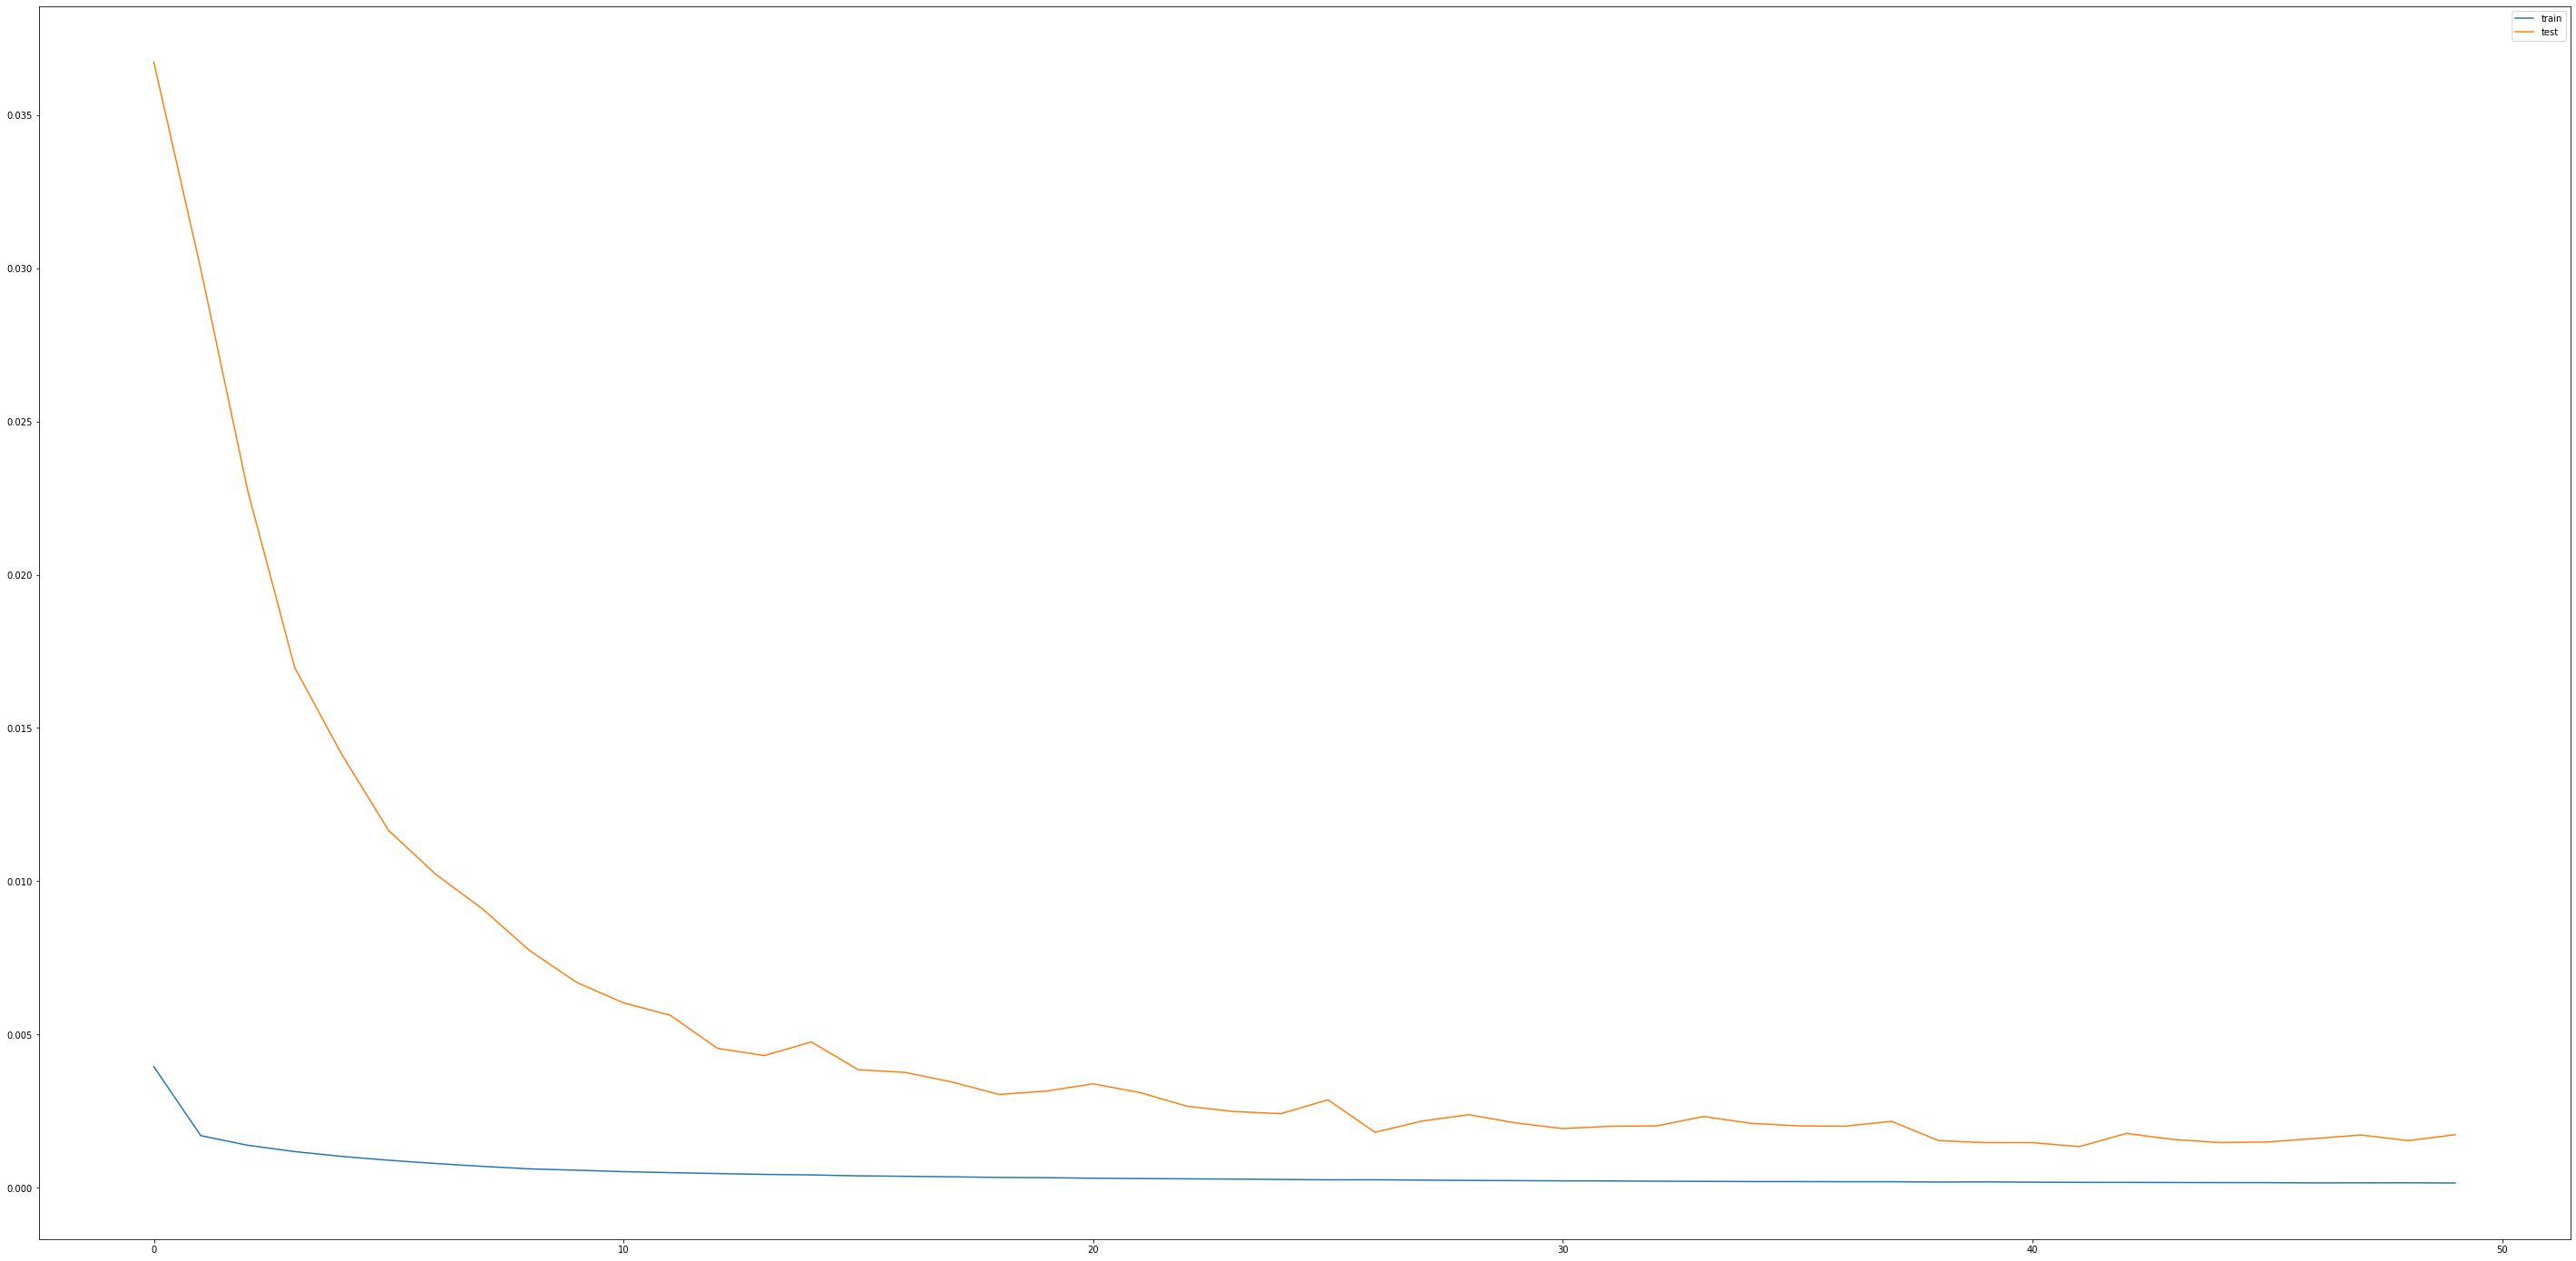

In [12]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='RMSprop')
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 5.788


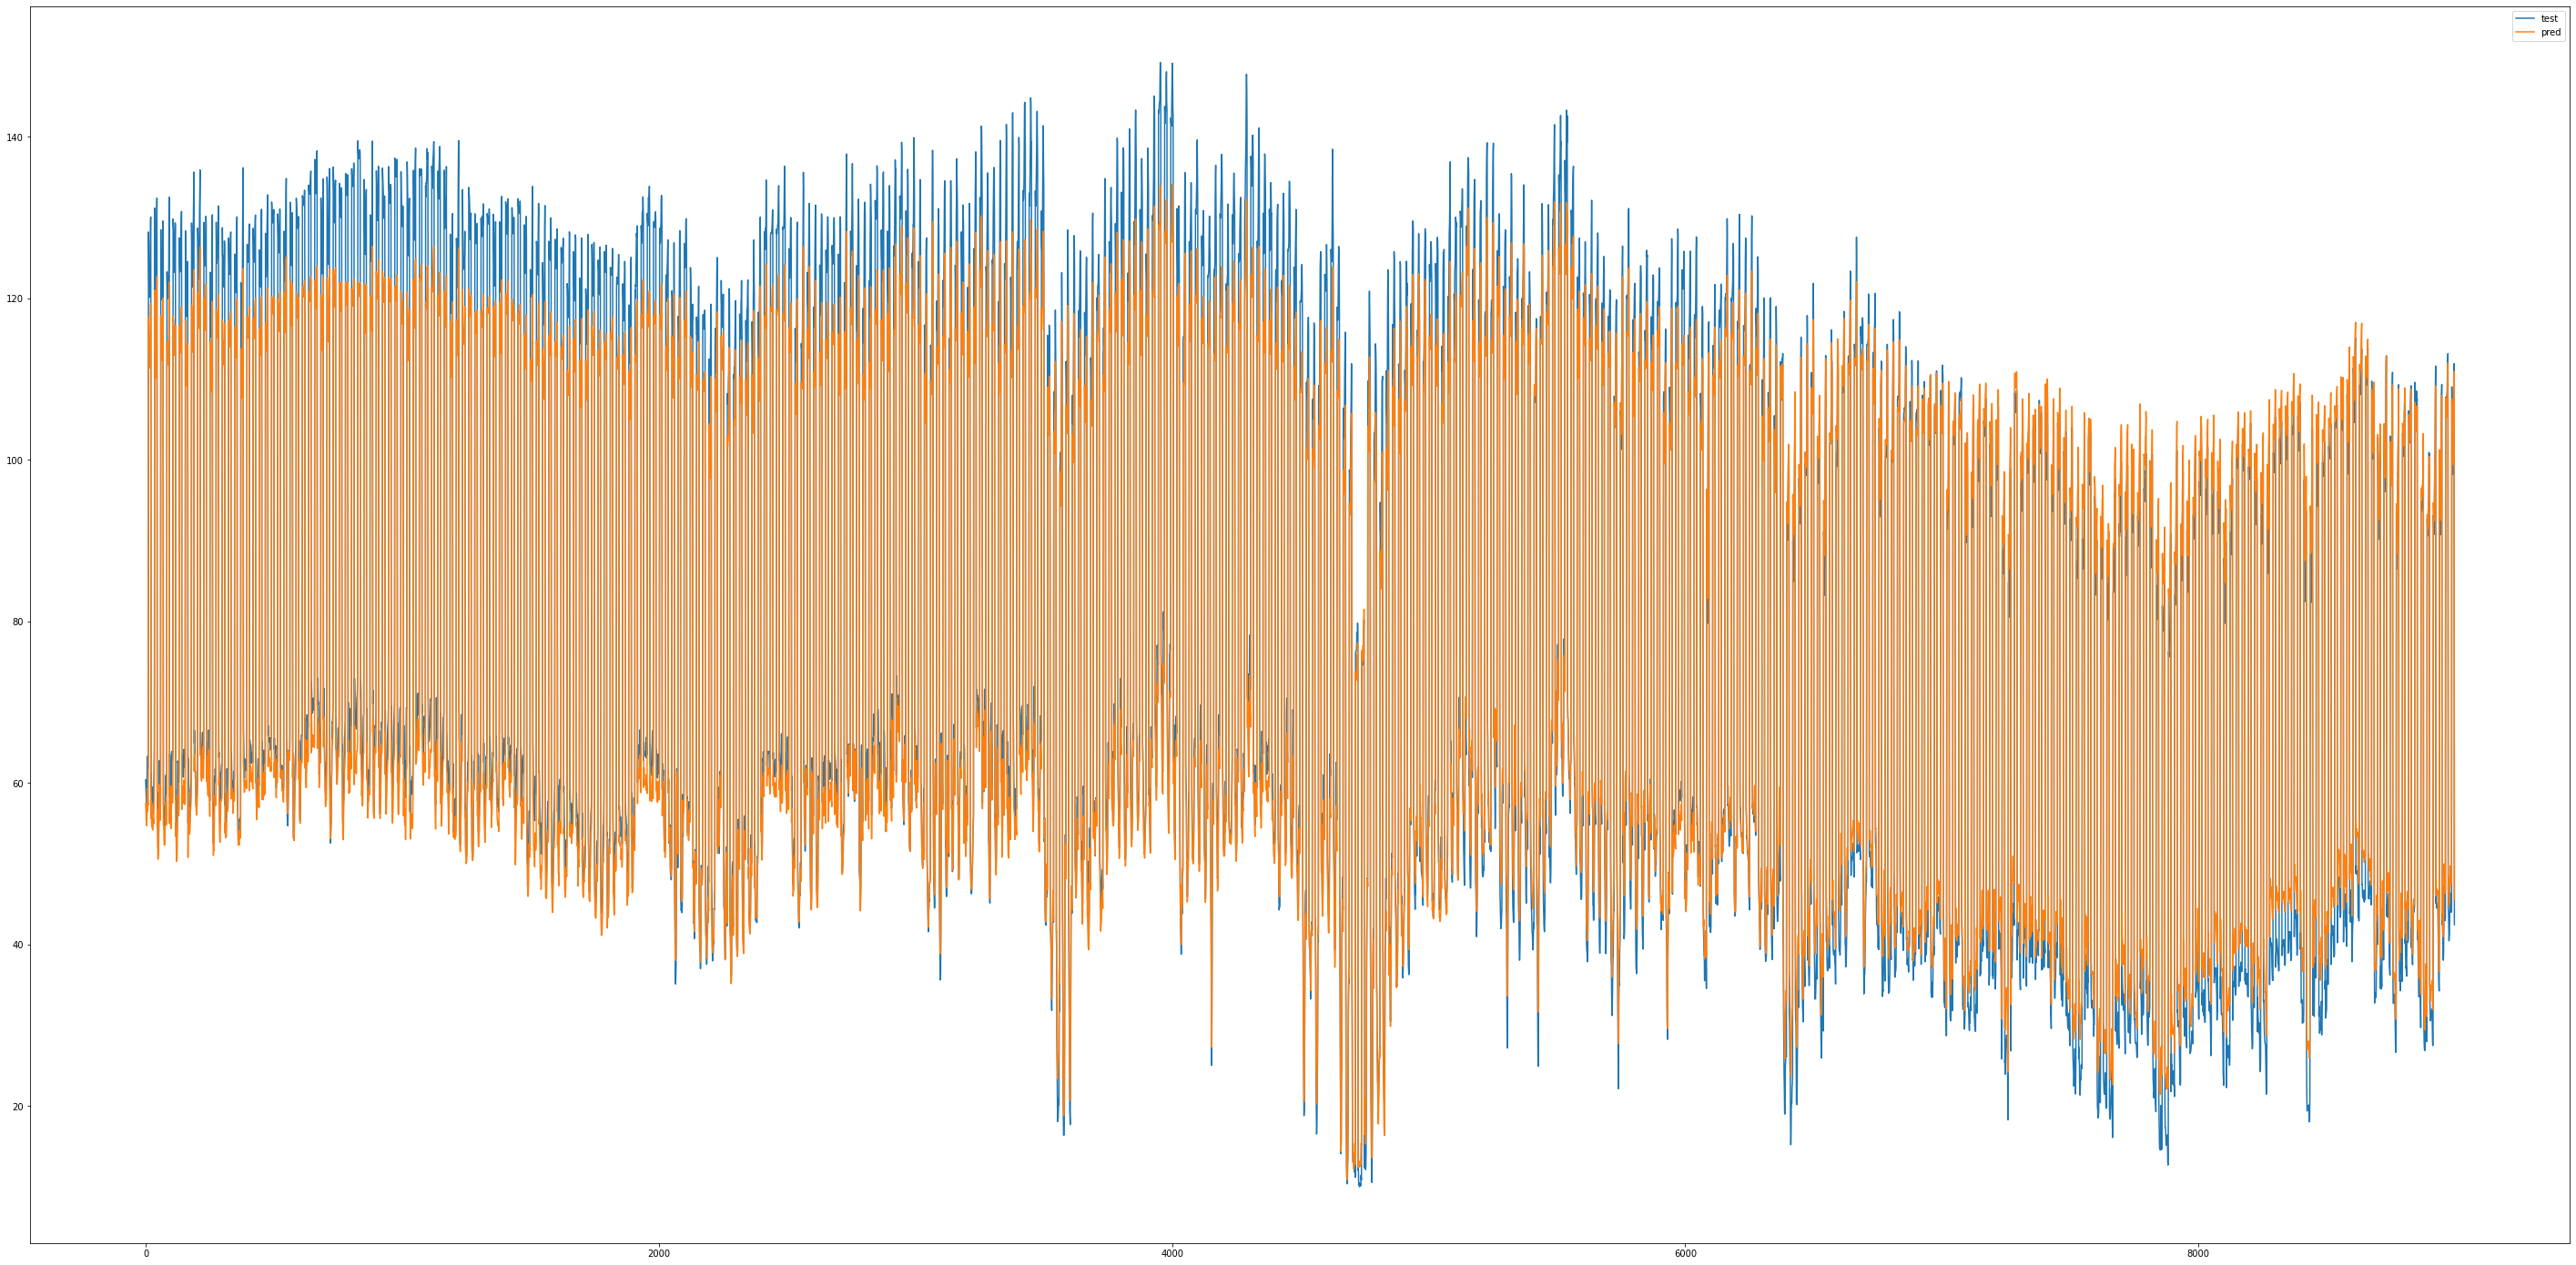

In [13]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.show()

In [4]:
model_columns = ['Demanda_programada_P48_total', 'Precio_mercado_SPOT_Diario','Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo','Generacion_programada_P48_Enlace_Baleares','Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hulla_antracita','Generacion_programada_P48_Hulla_sub-bituminosa','Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica','Generacion_programada_P48_Turbinacion_bombeo','IBEX35',
                 'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 'Weekday_Friday', 'Weekday_Saturday', 'holidays',
                 'Hour_0', 'Hour_1', 'Hour_2',
                 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 'Hour_22','Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [5]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original 'Weekday' column (you don't need it anymore)
df.drop(['Weekday','Hour','day','month','year'],axis=1, inplace=True)

In [6]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)
df.dropna(axis=0,how='any',inplace=True)

In [7]:
model_columns=df.columns.to_list()

model_columns = ['Demanda_programada_P48_total', 'Precio_mercado_SPOT_Diario','Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo','Generacion_programada_P48_Enlace_Baleares','Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hulla_antracita','Generacion_programada_P48_Hulla_sub-bituminosa','Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica','Generacion_programada_P48_Turbinacion_bombeo','IBEX35',
                 'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 'Weekday_Friday', 'Weekday_Saturday', 'holidays',
                 'Hour_0', 'Hour_1', 'Hour_2',
                 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 'Hour_22','Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [8]:
df

,Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA),Demanda_programada_P48_total,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Generacion_programada_P48_Biogas,Generacion_programada_P48_Biomasa,Generacion_programada_P48_Ciclo_combinado,...,Month_10,Month_11,Month_12,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020
datetime,,,,,,,,,,,,,,,,,,,,,
2014-04-01 00:00:00+00:00,45.01,22731.3,12.70,22.00,24.00,1000.0,0.0,0.0,427.2,1026.7,...,0,0,0,1,0,0,0,0,0,0
2014-04-01 01:00:00+00:00,46.37,22242.3,10.13,22.00,24.00,900.0,0.0,0.0,424.1,1029.7,...,0,0,0,1,0,0,0,0,0,0
2014-04-01 02:00:00+00:00,43.17,21870.2,10.00,15.00,18.00,1000.0,0.0,0.0,423.8,1036.7,...,0,0,0,1,0,0,0,0,0,0
2014-04-01 03:00:00+00:00,43.06,22386.3,10.00,20.00,22.00,850.0,0.0,0.0,420.5,1038.7,...,0,0,0,1,0,0,0,0,0,0
2014-04-01 04:00:00+00:00,50.90,24908.2,17.40,27.00,27.00,850.0,0.0,0.0,424.9,1109.1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-09 17:00:00+00:00,103.74,26292.0,30.02,30.53,30.62,-400.0,0.0,96.5,481.4,4838.7,...,0,0,0,0,0,0,0,0,0,1
2020-06-09 18:00:00+00:00,109.50,26558.2,31.51,32.01,32.50,-500.0,100.0,100.1,486.1,4972.5,...,0,0,0,0,0,0,0,0,0,1
2020-06-09 19:00:00+00:00,111.31,26985.4,32.83,32.83,32.84,-600.0,0.0,99.7,476.1,5023.7,...,0,0,0,0,0,0,0,0,0,1


In [9]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
y_train_aux = y.loc[:'2019-06-01 00:00:00+00:00',]
X_train_aux = X.loc[:'2019-06-01 00:00:00+00:00',model_columns]
y_test_aux = y.loc['2019-06-01 00:00:00+00:00':,]
X_test_aux = X.loc['2019-06-01 00:00:00+00:00':,model_columns]

X_train = X_train_aux.values
y_train = y_train_aux.values
X_test = X_test_aux.values
y_test = y_test_aux.values

# Normalizamos:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
#reshape y:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)

In [10]:
# Comprobamos el porcentaje de divivsión entre train y test
y_test.shape[0]/(y_train.shape[0]+y_test.shape[0])

0.16574870595170113

In [11]:
# Habrá que hacer un reshape para formatearlos para que entren en la red neuronal:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Epoch 1/50
453/453 - 1s - loss: 0.0039 - val_loss: 0.0367
Epoch 2/50
453/453 - 1s - loss: 0.0017 - val_loss: 0.0300
Epoch 3/50
453/453 - 1s - loss: 0.0014 - val_loss: 0.0227
Epoch 4/50
453/453 - 1s - loss: 0.0012 - val_loss: 0.0170
Epoch 5/50
453/453 - 1s - loss: 0.0010 - val_loss: 0.0141
Epoch 6/50
453/453 - 1s - loss: 8.9330e-04 - val_loss: 0.0117
Epoch 7/50
453/453 - 1s - loss: 7.8644e-04 - val_loss: 0.0102
Epoch 8/50
453/453 - 1s - loss: 6.9317e-04 - val_loss: 0.0091
Epoch 9/50
453/453 - 1s - loss: 6.1175e-04 - val_loss: 0.0077
Epoch 10/50
453/453 - 1s - loss: 5.6818e-04 - val_loss: 0.0067
Epoch 11/50
453/453 - 1s - loss: 5.2105e-04 - val_loss: 0.0060
Epoch 12/50
453/453 - 1s - loss: 4.8827e-04 - val_loss: 0.0056
Epoch 13/50
453/453 - 1s - loss: 4.5880e-04 - val_loss: 0.0045
Epoch 14/50
453/453 - 1s - loss: 4.3165e-04 - val_loss: 0.0043
Epoch 15/50
453/453 - 1s - loss: 4.1408e-04 - val_loss: 0.0048
Epoch 16/50
453/453 - 1s - loss: 3.8354e-04 - val_loss: 0.0038
Epoch 17/50
453/453 -

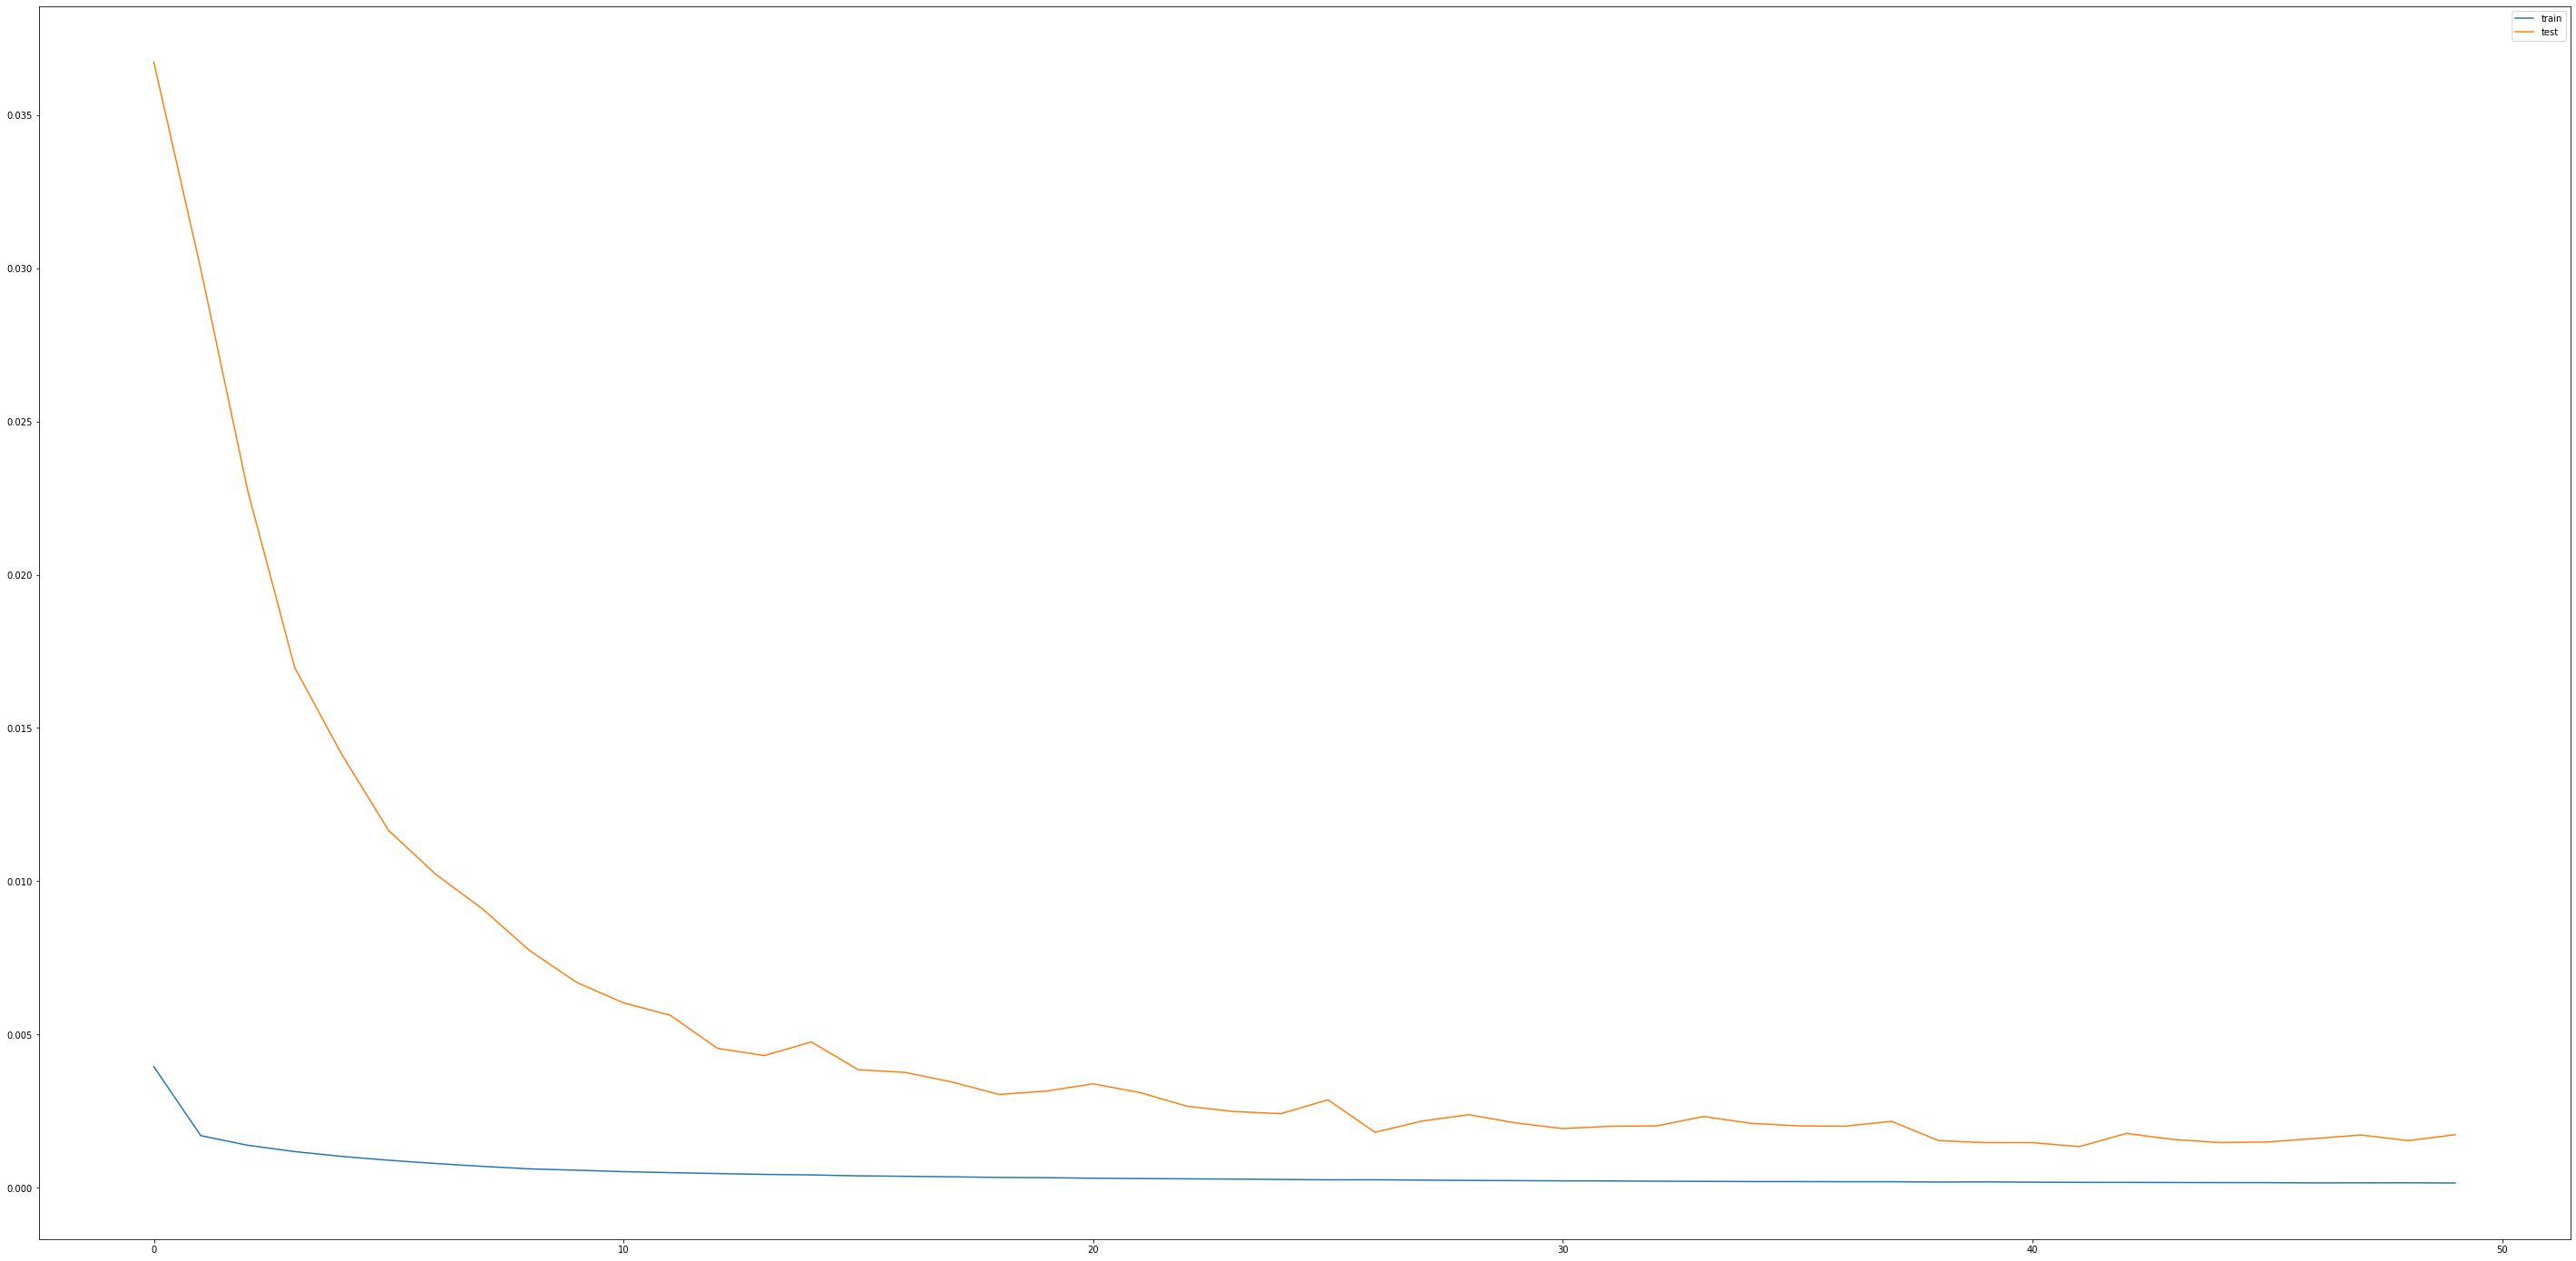

In [12]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='RMSprop')
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 5.788


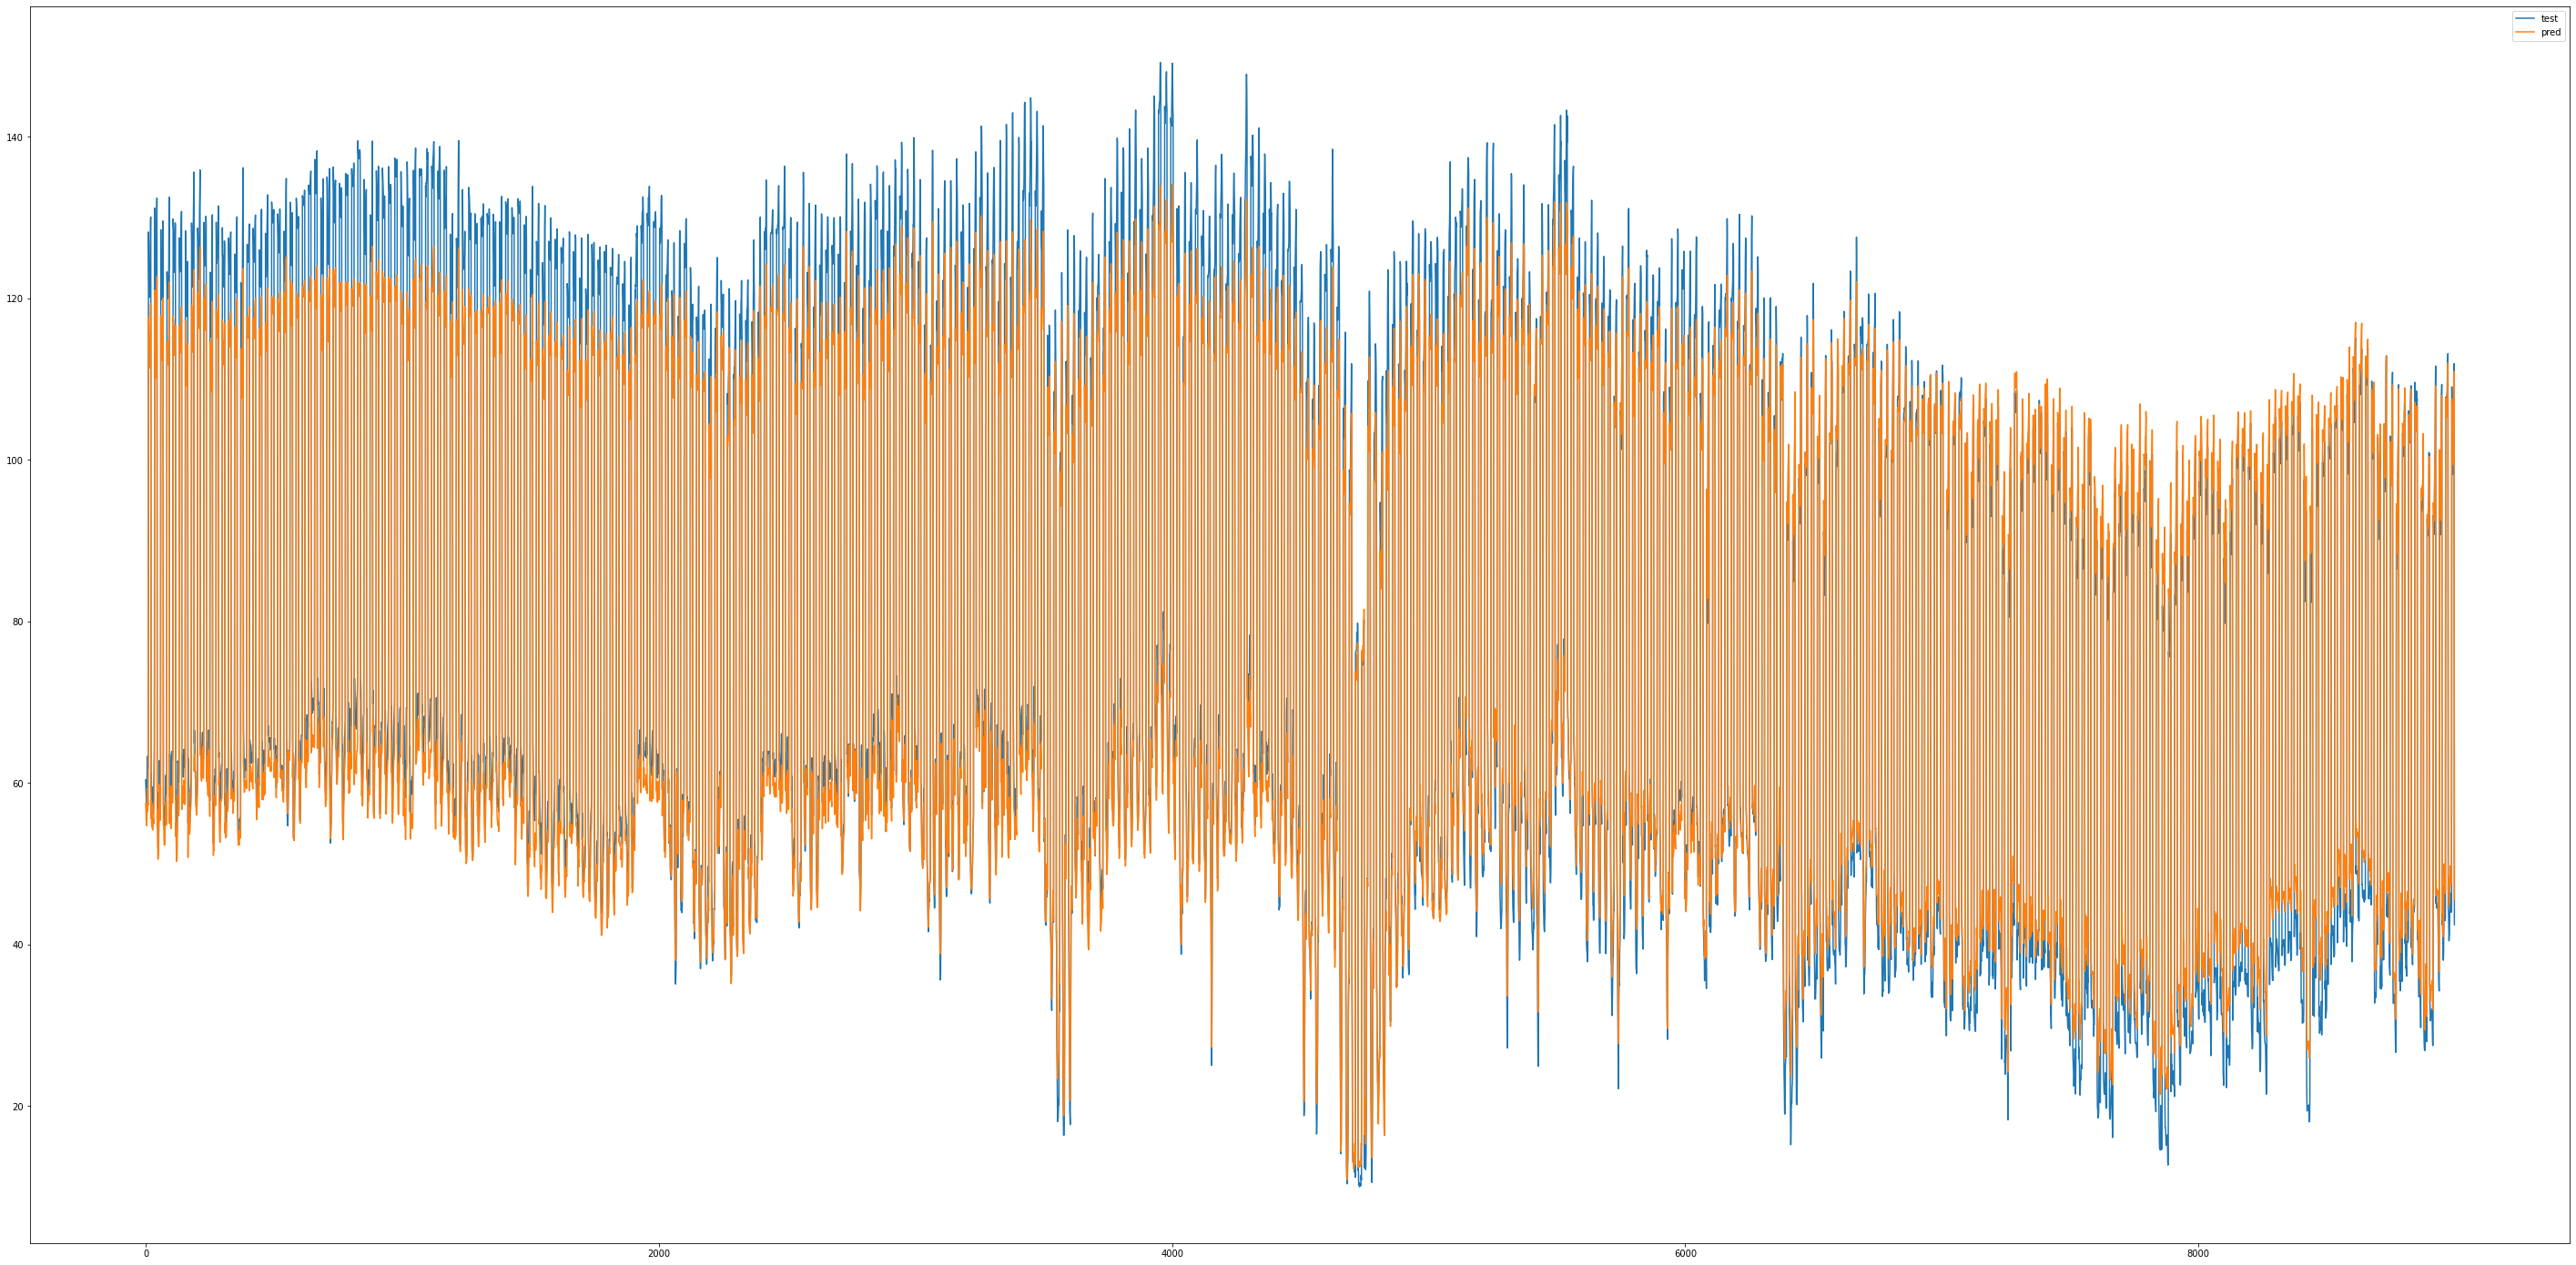

In [13]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.show()

Second model:

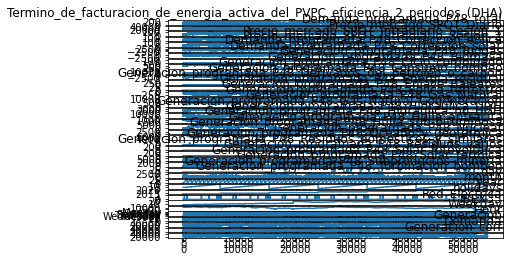

In [3]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

values = df.values
# specify columns to plot
groups = np.arange(len(df.columns.to_list()))
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.rcParams['figure.figsize'] = [50, 25]
plt.show()

In [4]:
model_columns = ['Demanda_programada_P48_total', 'Precio_mercado_SPOT_Diario','Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo','Generacion_programada_P48_Enlace_Baleares','Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hulla_antracita','Generacion_programada_P48_Hulla_sub-bituminosa','Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica','Generacion_programada_P48_Turbinacion_bombeo','IBEX35',
                 'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 'Weekday_Friday', 'Weekday_Saturday', 'holidays',
                 'Hour_0', 'Hour_1', 'Hour_2',
                 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 'Hour_22','Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [5]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original 'Weekday' column (you don't need it anymore)
df.drop(['Weekday','Hour','day','month','year'],axis=1, inplace=True)

In [6]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)
df.dropna(axis=0,how='any',inplace=True)

In [7]:
model_columns=df.columns.to_list()

model_columns = ['Demanda_programada_P48_total', 'Precio_mercado_SPOT_Diario','Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo','Generacion_programada_P48_Enlace_Baleares','Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hulla_antracita','Generacion_programada_P48_Hulla_sub-bituminosa','Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica','Generacion_programada_P48_Turbinacion_bombeo','IBEX35',
                 'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 'Weekday_Friday', 'Weekday_Saturday', 'holidays',
                 'Hour_0', 'Hour_1', 'Hour_2',
                 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 'Hour_22','Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [36]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
y_train_aux = y.loc[:'2019-06-01 00:00:00+00:00',]
X_train_aux = X.loc[:'2019-06-01 00:00:00+00:00',model_columns]
y_test_aux = y.loc['2019-06-01 00:00:00+00:00':,]
X_test_aux = X.loc['2019-06-01 00:00:00+00:00':,model_columns]

X_train = X_train_aux.values
y_train = y_train_aux.values
X_test = X_test_aux.values
y_test = y_test_aux.values

# Normalizamos:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
#reshape y:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)

In [37]:
# Comprobamos el porcentaje de divivsión entre train y test
y_test.shape[0]/(y_train.shape[0]+y_test.shape[0])

0.16574870595170113

In [38]:
# Habrá que hacer un reshape para formatearlos para que entren en la red neuronal:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Epoch 1/100
1416/1416 - 8s - loss: 0.0059 - val_loss: 0.0315
Epoch 2/100
1416/1416 - 7s - loss: 0.0027 - val_loss: 0.0319
Epoch 3/100
1416/1416 - 7s - loss: 0.0024 - val_loss: 0.0319
Epoch 4/100
1416/1416 - 7s - loss: 0.0023 - val_loss: 0.0322
Epoch 5/100
1416/1416 - 9s - loss: 0.0022 - val_loss: 0.0314
Epoch 6/100
1416/1416 - 9s - loss: 0.0021 - val_loss: 0.0307
Epoch 7/100
1416/1416 - 8s - loss: 0.0019 - val_loss: 0.0293
Epoch 8/100
1416/1416 - 7s - loss: 0.0017 - val_loss: 0.0284
Epoch 9/100
1416/1416 - 7s - loss: 0.0016 - val_loss: 0.0272
Epoch 10/100
1416/1416 - 7s - loss: 0.0014 - val_loss: 0.0251
Epoch 11/100
1416/1416 - 7s - loss: 0.0013 - val_loss: 0.0244
Epoch 12/100
1416/1416 - 7s - loss: 0.0011 - val_loss: 0.0236
Epoch 13/100
1416/1416 - 7s - loss: 9.7115e-04 - val_loss: 0.0236
Epoch 14/100
1416/1416 - 7s - loss: 8.9354e-04 - val_loss: 0.0211
Epoch 15/100
1416/1416 - 7s - loss: 8.4989e-04 - val_loss: 0.0195
Epoch 16/100
1416/1416 - 7s - loss: 8.2622e-04 - val_loss: 0.0198
E

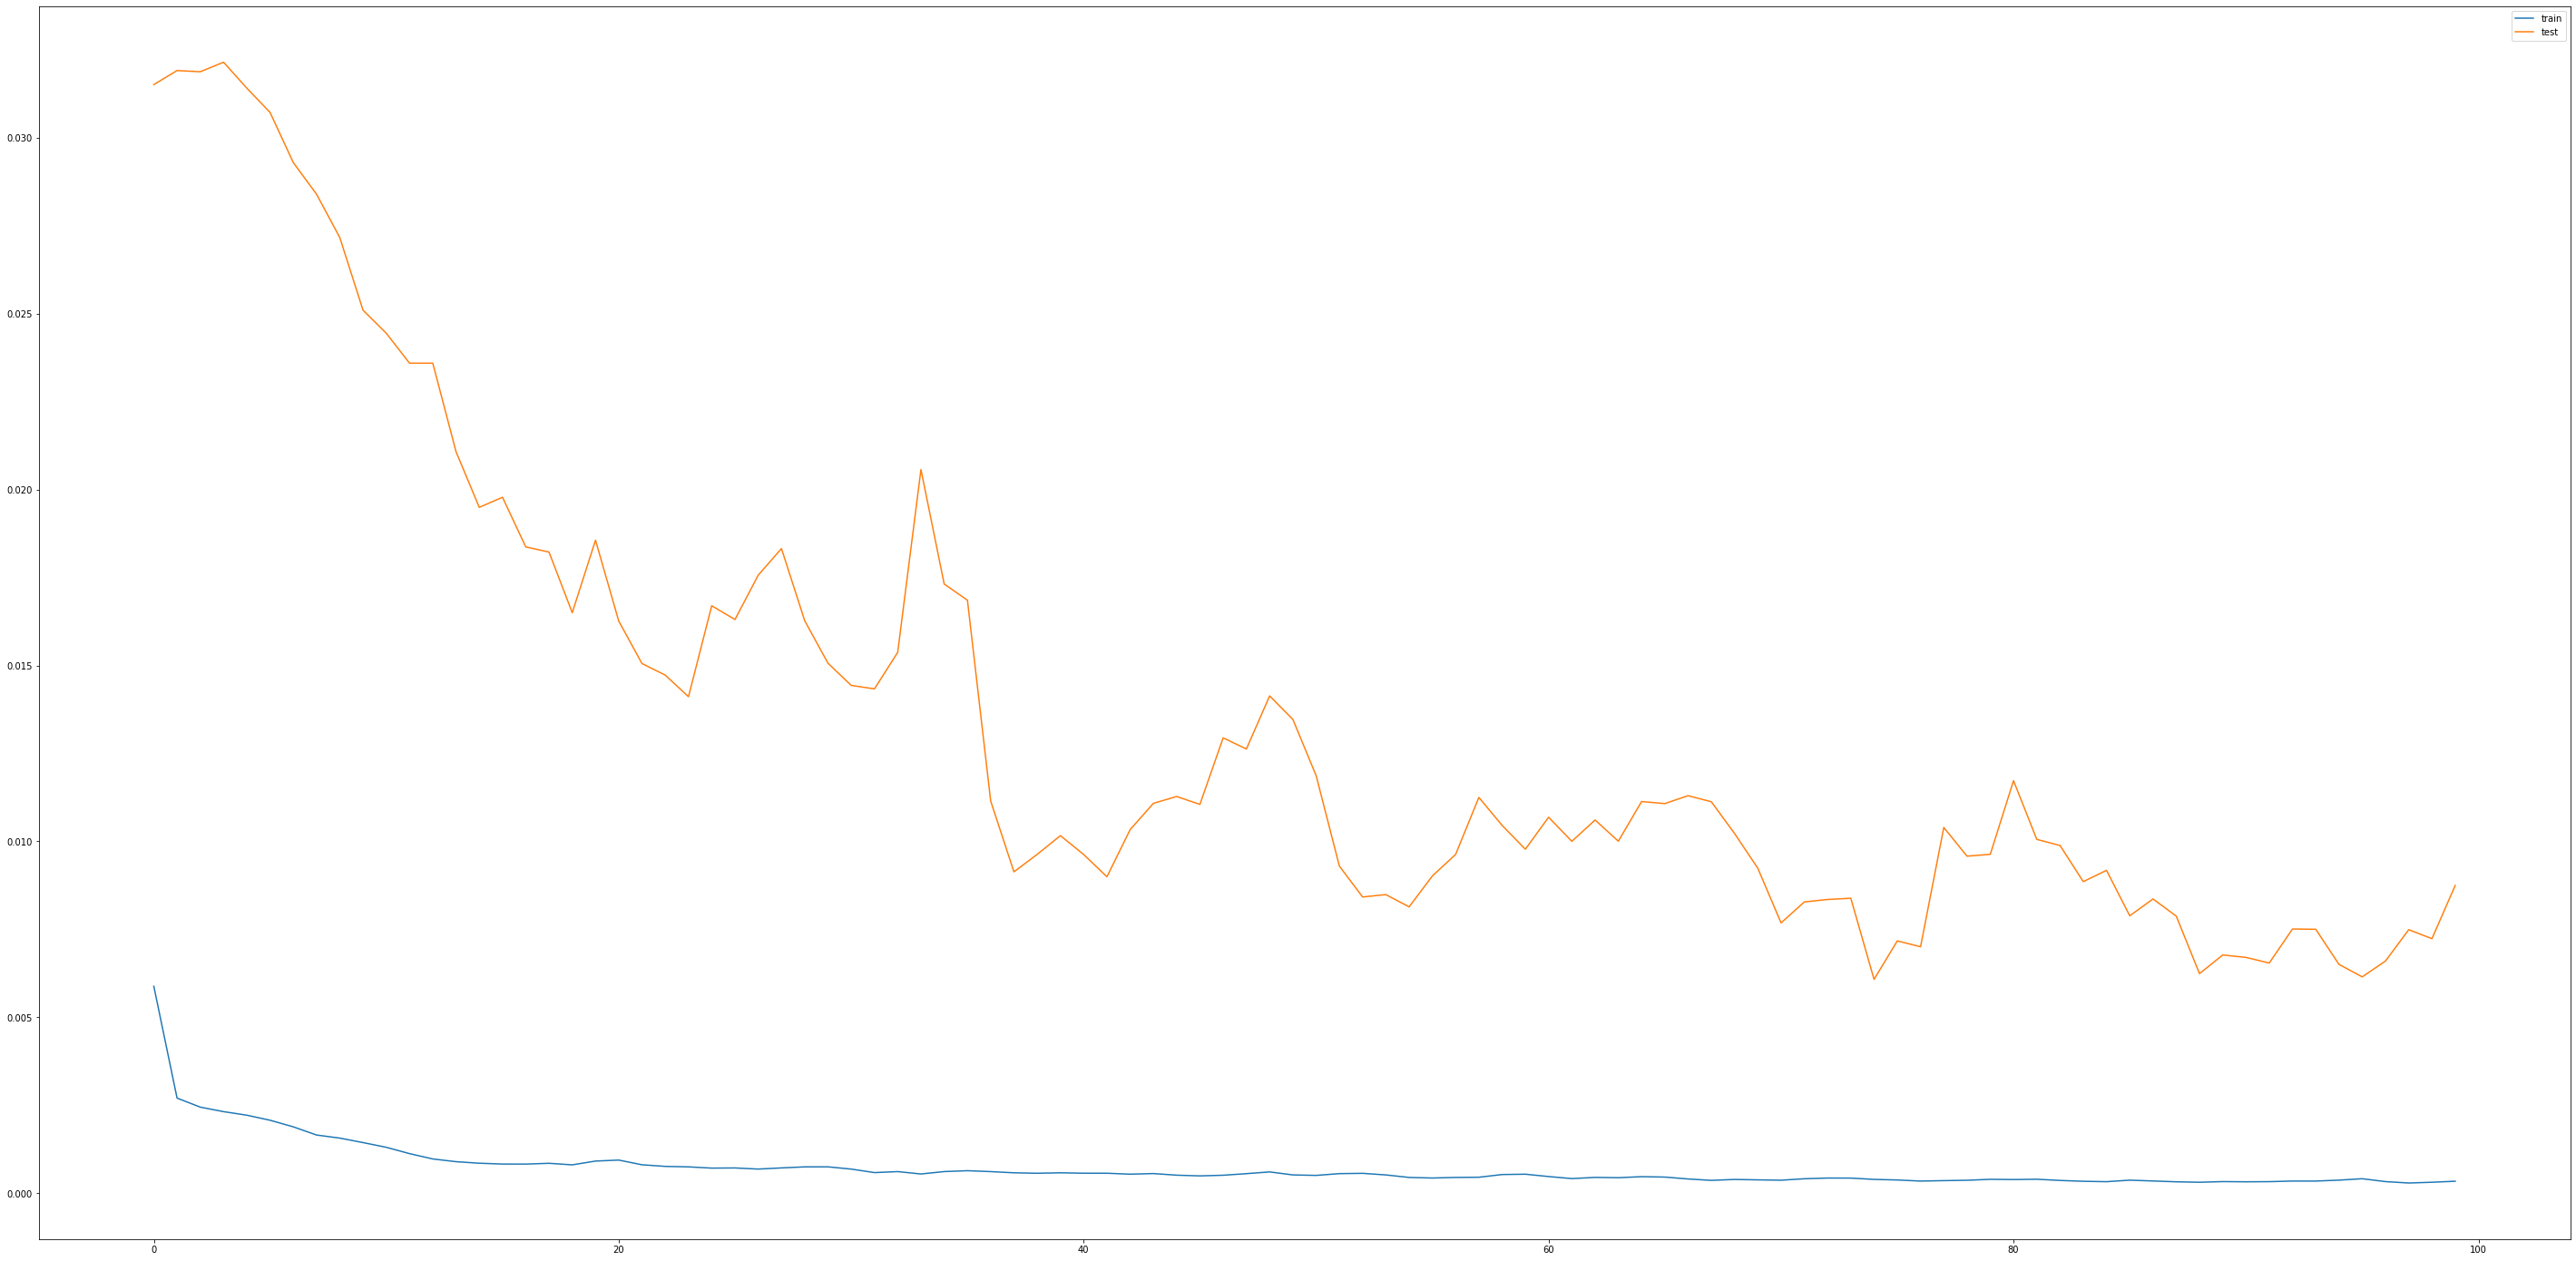

In [39]:
# design network
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 13.021


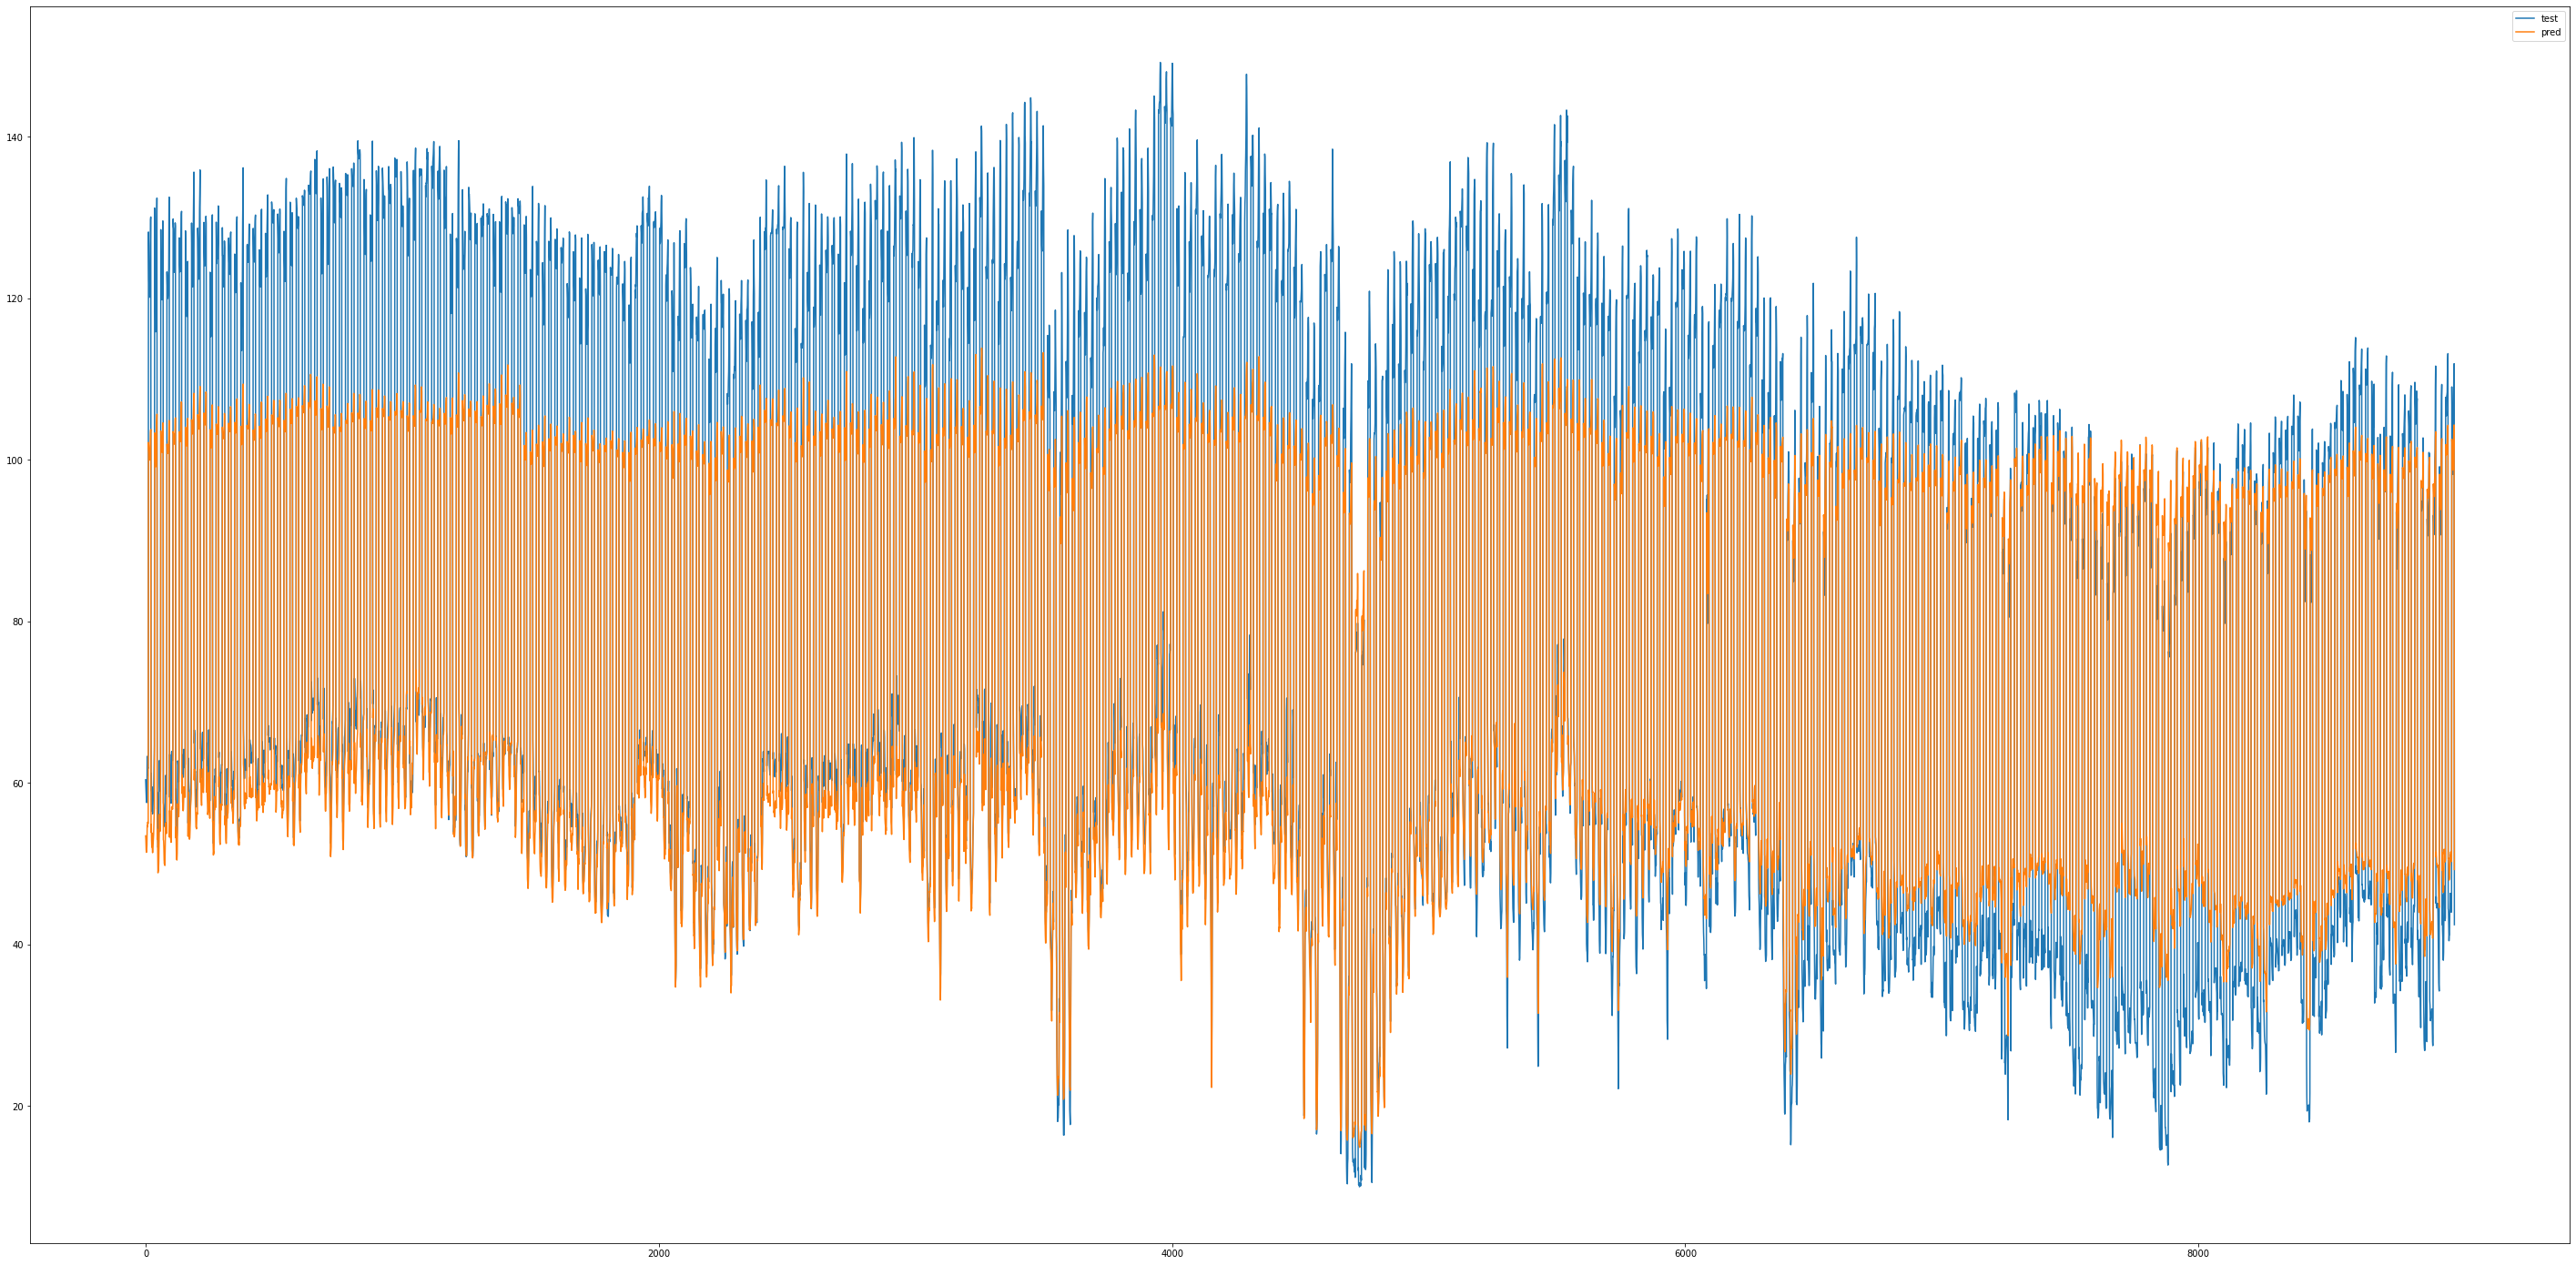

In [40]:
# make a prediction
yhat = regressor.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.show()

# Tercer modelo

In [2]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

In [3]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original 'Weekday' column (you don't need it anymore)
df.drop(['Weekday','Hour','day','month','year'],axis=1, inplace=True)

In [4]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)
df.dropna(axis=0,how='any',inplace=True)

In [5]:
model_columns=df.columns.to_list()

In [6]:
X = df.loc[:,]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
y_train_aux = y.loc[:'2019-06-01 00:00:00+00:00',]
X_train_aux = X.loc[:'2019-06-01 00:00:00+00:00',]
y_test_aux = y.loc['2019-06-01 00:00:00+00:00':,]
X_test_aux = X.loc['2019-06-01 00:00:00+00:00':,]

X_train = X_train_aux.values
y_train = y_train_aux.values
X_test = X_test_aux.values
y_test = y_test_aux.values

# Normalizamos:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
#reshape y:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)

In [7]:
# Comprobamos el porcentaje de divivsión entre train y test
y_test.shape[0]/(y_train.shape[0]+y_test.shape[0])

0.16574870595170113

In [8]:
# Habrá que hacer un reshape para formatearlos para que entren en la red neuronal:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Epoch 1/50
453/453 - 1s - loss: 0.0041 - val_loss: 0.0300
Epoch 2/50
453/453 - 1s - loss: 0.0017 - val_loss: 0.0285
Epoch 3/50
453/453 - 1s - loss: 0.0014 - val_loss: 0.0246
Epoch 4/50
453/453 - 1s - loss: 0.0012 - val_loss: 0.0211
Epoch 5/50
453/453 - 1s - loss: 0.0010 - val_loss: 0.0195
Epoch 6/50
453/453 - 1s - loss: 8.9291e-04 - val_loss: 0.0177
Epoch 7/50
453/453 - 1s - loss: 7.8081e-04 - val_loss: 0.0159
Epoch 8/50
453/453 - 1s - loss: 7.0393e-04 - val_loss: 0.0158
Epoch 9/50
453/453 - 1s - loss: 6.3639e-04 - val_loss: 0.0130
Epoch 10/50
453/453 - 1s - loss: 5.8694e-04 - val_loss: 0.0095
Epoch 11/50
453/453 - 1s - loss: 5.5052e-04 - val_loss: 0.0089
Epoch 12/50
453/453 - 1s - loss: 5.0294e-04 - val_loss: 0.0099
Epoch 13/50
453/453 - 1s - loss: 4.6283e-04 - val_loss: 0.0092
Epoch 14/50
453/453 - 1s - loss: 4.5300e-04 - val_loss: 0.0081
Epoch 15/50
453/453 - 1s - loss: 4.1994e-04 - val_loss: 0.0082
Epoch 16/50
453/453 - 1s - loss: 4.1022e-04 - val_loss: 0.0073
Epoch 17/50
453/453 -

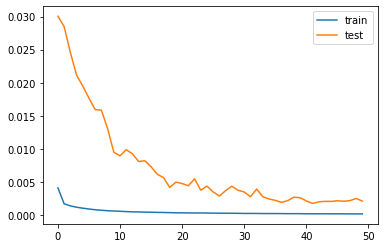

In [9]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='RMSprop')
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 6.382


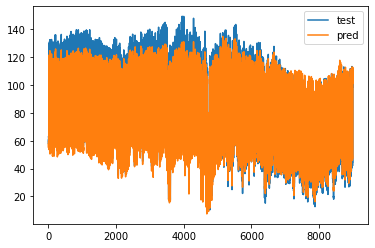

In [10]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plt.plot(inv_y, label='test')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.show()